### Import Libraries

In [340]:
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

### 1. Pre-processing

In [341]:
sample_rate = 16000
frame_length = int(0.032 * sample_rate)  # 32ms
hop_length = frame_length//2    # 16ms

In [342]:
def select_cry_frames_using_energy(signal: np.ndarray, frame_length, hop_length, thresh=0.05) -> list:
    energy = np.array([
        sum(abs(signal[i:i+frame_length]**2))
        for i in range(0, len(signal), hop_length)
    ])
    energy_norm = energy / max(energy)
    index_cry = [i for i in range(len(energy)) if energy_norm[i] >= thresh]
    return index_cry

def split_segments(index_voices: list, hop_length, sr, duration_ms=100) -> list:
    """
    Chia các khung tiếng khóc thành các phân đoạn có độ dài chính xác theo ms (200ms).
    """
    # Tính số frame tương ứng với 200ms
    frames_per_segment = int(duration_ms * sr / 1000 / hop_length)
    
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            # Khi có một khoảng cách giữa các khung lớn hơn 1 frame, thêm phân đoạn trước đó
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    # Thêm phân đoạn cuối cùng
    segments.append((start, index_voices[-1]))

    # Chỉ giữ lại những phân đoạn có đúng số frame tương ứng với 200ms
    return [(start, end) for start, end in segments if (end - start) == frames_per_segment]

### 2. Features Extraction

In [343]:
def extract_features(y, sr, n_mfcc=12, n_fft=1024):
    # Trích xuất đặc trưng thời gian
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)

    # Trích xuất đặc trưng tần số
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # # Trích xuất MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

    # # Trích xuất Mel-spectrogram
    # mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=frame_length, n_mels=15)

    # # Tính pitch (f0)
    # f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=250, fmax=700, sr=sr, frame_length=frame_length, hop_length=hop_length)
    # f0 = np.nan_to_num(f0)  # Chuyển NaNs thành 0

    # Kết hợp các đặc trưng thành mảng 2D theo từng khung tín hiệu
    features = np.concatenate([ mfcc, zcr, rms], axis=0)
    features = features.reshape(-1)
    return features  # Trả về mảng theo dạng (số khung, số đặc trưng)

In [344]:
# def extract_features(signal, sr, n_mfcc=12, n_fft=2048):
#     # Trích xuất MFCC (Mel Frequency Cepstral Coefficients)
#     mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
#     mfccs_mean = np.mean(mfccs, axis=1)  # Trả về giá trị trung bình của MFCC qua toàn bộ tín hiệu
    
#     mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=frame_length, n_mels=15)
#     mel_scale = np.mean(mel_spectrogram, axis=1)  # Tính trung bình theo chiều dọc
    
#     # Trích xuất Zero-Crossing Rate (ZCR)
#     zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=frame_length, hop_length=hop_length)
#     zcr_mean = np.mean(zcr)  # Trả về giá trị trung bình của Zero-Crossing Rate
    
    
#     # Trả về tất cả các đặc trưng: MFCCs, RMS, và Zero-Crossing Rate
#     return np.concatenate([mfccs_mean, mel_scale])

In [345]:
data_dir = 'data_bbcry_classification'

for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    
    if os.path.isdir(class_dir):
        file_count = len(os.listdir(class_dir)) 
        print(f"Lớp {label} có {file_count} file.")

Lớp belly_pain có 48 file.
Lớp burping có 24 file.
Lớp discomfort có 54 file.
Lớp hungry có 45 file.
Lớp tired có 48 file.


In [346]:
# X = []
# y = []

# # Duyệt qua từng lớp
# for label in os.listdir(data_dir):
#     class_dir = os.path.join(data_dir, label)
#     if not os.path.isdir(class_dir):
#         continue
#     for file_name in os.listdir(class_dir):
#         file_path = os.path.join(class_dir, file_name)
        
#         # Load file âm thanh
#         signal, sr = librosa.load(file_path, sr=16000)
#         features = extract_features(signal, sr)
#         X.append(features)
#         y.append(label)

In [347]:
X = []
y = []

# Duyệt qua từng lớp
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        
        # Load file âm thanh
        signal, sr = librosa.load(file_path, sr=16000)
        
        # Chọn các frame chứa tiếng khóc dựa vào năng lượng chuẩn hóa
        index_cry = select_cry_frames_using_energy(signal, frame_length, hop_length)
        
        # Chia các frame thành các segment
        segments = split_segments(index_cry, hop_length, sr)
        
        # Trích xuất đặc trưng cho từng segment
        for (start, end) in segments:
            segment = signal[start * hop_length : end * hop_length]
            features = extract_features(segment, sr)
            X.append(features)
            y.append(label)

In [348]:
print("Kích thước của X:", np.shape(X))
print("Kích thước của y:", np.shape(y))

Kích thước của X: (71, 98)
Kích thước của y: (71,)


### 3. Train Test Split

In [349]:
# Chuyển đổi nhãn sang dạng số
le = LabelEncoder()
y = le.fit_transform(y)

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [350]:
print("Kích thước của X_train:", np.shape(X_train))
print("Kích thước của X_test:", np.shape(X_test))
print("Kích thước của y_train:", np.shape(y_train))
print("Kích thước của y_test:", np.shape(y_test))

Kích thước của X_train: (49, 98)
Kích thước của X_test: (22, 98)
Kích thước của y_train: (49,)
Kích thước của y_test: (22,)


### 4. Training Model

Model: Random Forest, Accuracy: 0.545455, F1 score: 0.481385
Model: Bagged Tree, Accuracy: 0.454545, F1 score: 0.417464
Model: KNN, Accuracy: 0.545455, F1 score: 0.555981
       Algorithm  Accuracy Score  F1 Score
0  Random Forest        0.545455  0.481385
1    Bagged Tree        0.454545  0.417464
2            KNN        0.545455  0.555981


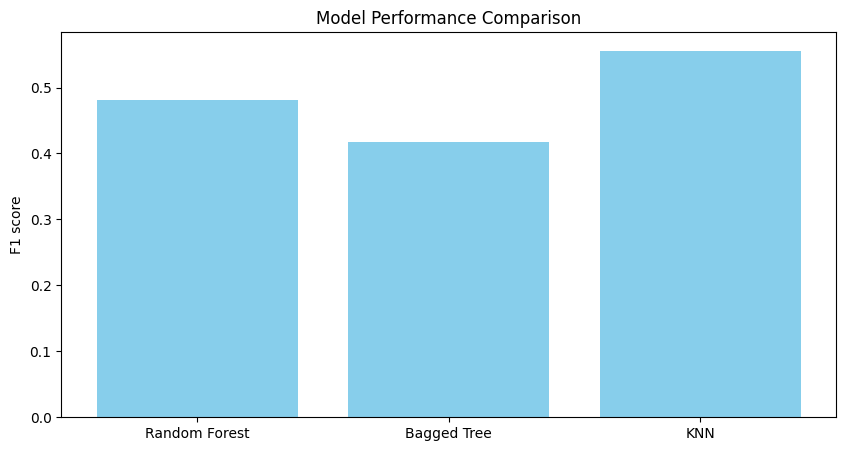

In [351]:
# Huấn luyện và đánh giá mô hình
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Bagged Tree': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100),
    'KNN':  KNeighborsClassifier(n_neighbors=4),
    # 'SVM': SVC(kernel='linear', C=1, random_state=42),
}

results = []
# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.6f}, F1 score: {f1:.6f}")
    results.append({'Algorithm': model_name, 'Accuracy Score': accuracy, 'F1 Score': f1})


results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(10, 5))
plt.bar(results_df['Algorithm'], results_df['F1 Score'], color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('F1 score')
plt.show()

#### Confusion matrix

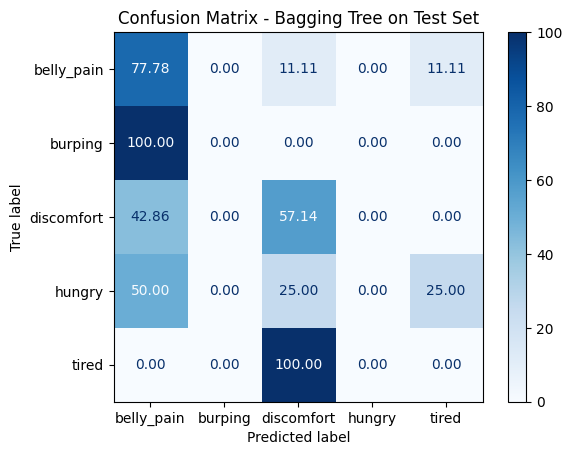

In [352]:

# Huấn luyện mô hình Random Forest
bg_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
bg_model.fit(X_train, y_train)

y_pred = bg_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'cold_hot', 'discomfort', 'scared','tired'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'discomfort', 'hungry','tired'])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'discomfort','tired'])
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Bagging Tree on Test Set")
plt.show()

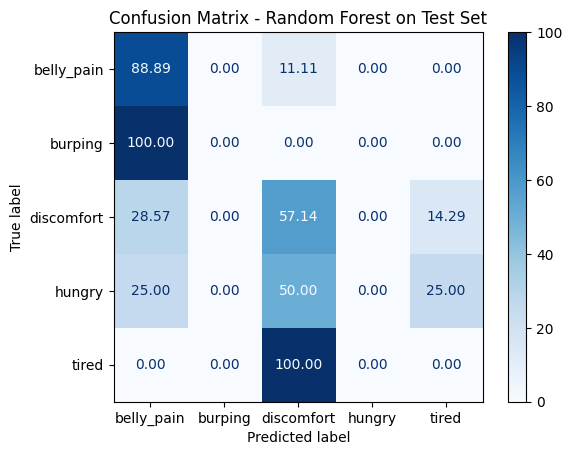

In [353]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'cold_hot', 'discomfort', 'scared','tired'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'discomfort', 'hungry','tired'])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'discomfort','tired'])
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Random Forest on Test Set")
plt.show()

In [354]:
# import joblib

# model_filename = 'randomforest_model.pkl'

# # Lưu mô hình
# joblib.dump(rf_model, model_filename)

# print(f"Mô hình đã được lưu thành công tại {model_filename}")

In [355]:
# Đọc và trích xuất MFCC từ các tệp âm thanh trong thư mục testing
def extract_features_from_testing_directory(testing_dir):
    X_test_files = []
    for file_name in os.listdir(testing_dir):
        file_path = os.path.join(testing_dir, file_name)
        
        if not os.path.isfile(file_path):
            continue
        
        signal, sr = librosa.load(file_path, sr=16000)
        
        features = extract_features(signal, sr)
        
        if features is not None:
            X_test_files.append(features)
        else:
            print(f"Warning: No MFCC extracted for {file_path}")
    
    if len(X_test_files) > 0:
        return np.array(X_test_files)  #
    else:
        return np.array([])  

# Dự đoán các tệp trong thư mục testing
def predict_testing_files(model_name, testing_dir, label_encoder):
    X_test_files = extract_features_from_testing_directory(testing_dir)
    
    if X_test_files.size == 0:
        print("No valid files found in testing directory or MFCC extraction failed.")
        return

    y_pred = model_name.predict(X_test_files)
    
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    
    for i, file_name in enumerate(os.listdir(testing_dir)):
        file_path = os.path.join(testing_dir, file_name)
        
        if not os.path.isfile(file_path):
            continue
        
        predicted_class = y_pred_labels[i]
        print(f"File: {file_name} - Predicted Class: {predicted_class}")
label_encoder = LabelEncoder()
# label_encoder.fit(['belly_pain', 'burping', 'cold_hot', 'discomfort', 'scared', 'tired'])
label_encoder.fit(['belly_pain', 'burping', 'discomfort', 'hungry', 'tired'])
# label_encoder.fit(['belly_pain', 'burping', 'discomfort','tired'])

testing_dir = 'testing_function2/dc' 
predict_testing_files(rf_model, testing_dir, label_encoder)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.